In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from scipy.stats import chi2_contingency
import scipy.stats as stats

## Check expression to RNA normalized data

In [4]:
raw = pd.read_csv('/nrnb/users/mpagadal/tcga-genotypes/germline-immune/hla.snp.raw',sep=' ')
raw["6:29933439:T:C_T"]=raw["6:29933439:T:C_C"].map({2:0,1:1,0:2})
raw.head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,6:26364628:A:C_C,6:26370605:T:C_C,6:27410422:G:A_A,6:28741734:C:A_A,...,6:32804570:G:A_A,6:32850839:C:T_T,6:32852448:C:T_T,6:32853511:G:A_A,6:32899485:G:A_A,6:32900718:G:A_A,6:33049074:G:T_T,6:33064393:G:A_A,6:33077271:A:G_G,6:29933439:T:C_T
0,TCGA-01-0628,TCGA-01-0628,0,0,2,-9,0,1,0,0,...,0,0,0,0,2,0,0,0,0,2
1,TCGA-01-0630,TCGA-01-0630,0,0,2,-9,1,2,1,0,...,1,0,0,0,0,1,1,0,1,2
2,TCGA-01-0633,TCGA-01-0633,0,0,2,-9,0,2,0,0,...,1,0,0,0,1,0,0,0,0,1
3,TCGA-01-0636,TCGA-01-0636,0,0,2,-9,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,TCGA-01-0637,TCGA-01-0637,0,0,2,-9,0,2,0,0,...,1,0,0,0,0,0,0,0,2,1


In [5]:
tpm=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/tumor/pheno_all_zcancer",delimiter="\t")
firebrowse=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/tumor/pheno_all_zcancer",delimiter="\t")
pancan=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/tumor/pheno_all_zcancer",delimiter="\t")
ase=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/hla-deep-dive/phenotypes/hla-ase/avg/pheno_all_zcancer",delimiter="\t")

In [6]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()

tpm["cancer"]=tpm["FID"].map(mp)
firebrowse["cancer"]=firebrowse["FID"].map(mp)
pancan["cancer"]=pancan["FID"].map(mp)

In [7]:
geno_immune=pd.merge(raw,pancan,on=["FID","IID"])

In [8]:
snp="6:29933439"
snp=[x for x in geno_immune.columns if snp in x][0]
gene="HLA.A"

In [9]:
geno_immune_gene=geno_immune[~(geno_immune[gene]==-9)]

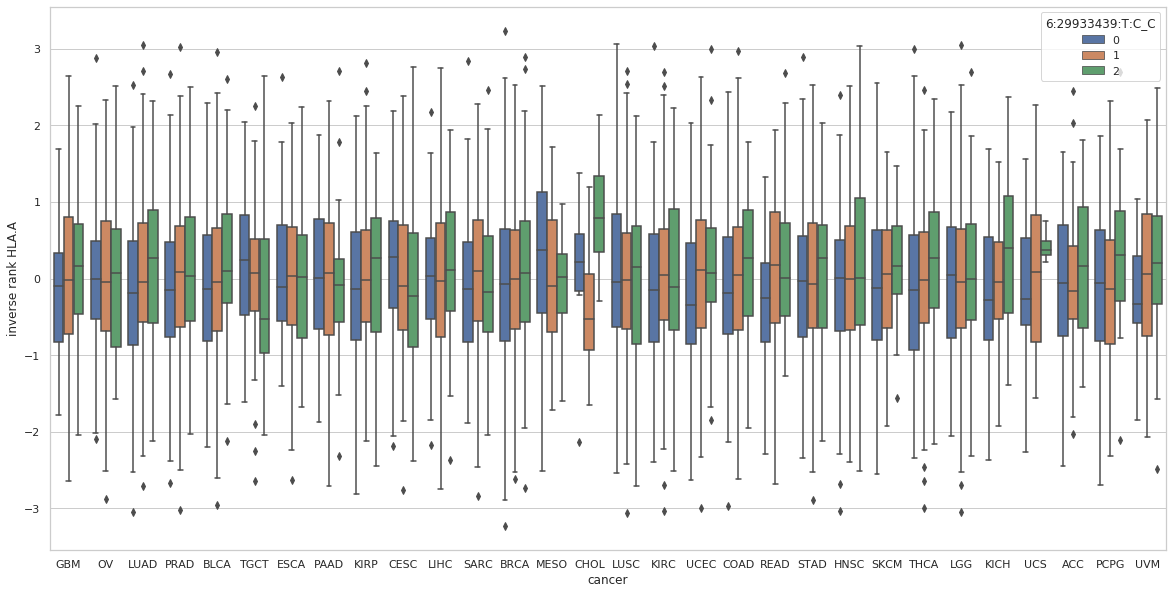

In [10]:
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,10))
ax=sns.boxplot(x="cancer",y=gene,data=geno_immune_gene,hue=snp)

#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels=[x+"\nn="+str(len(geno_immune_gene[geno_immune_gene[snp]==int(x)])) for x in labels]

#ax.set_xticklabels(labels)
plt.ylabel("inverse rank "+gene)

plt.savefig("/cellar/users/mpagadal/Data/projects/germline-immune/investigation/plots/"+snp+"."+gene+".pdf")

In [11]:
ld=raw.groupby(["6:29933439:T:C_C","6:29910358:G:C_C"]).size().reset_index()
ld=ld.pivot(index="6:29933439:T:C_C",columns="6:29910358:G:C_C",values=0)

In [12]:
ld

6:29910358:G:C_C,0,1,2
6:29933439:T:C_C,,,
0,460,1141,748
1,1026,2092,930
2,578,917,325


In [13]:
chi2_contingency(ld.values)

(152.25419279953582,
 6.693127406642822e-32,
 4,
 array([[ 590.03723987, 1186.36363636,  572.59912377],
        [1016.80321285, 2044.44444444,  986.7523427 ],
        [ 457.15954728,  919.19191919,  443.64853353]]))

## See correlation of HLA-A genotypes

In [14]:
polysolver_mhcI=pd.read_csv("/cellar/users/andreabc/Data/TCGA/hla_types/all_mhc_i_types.txt",delimiter="\t")
polysolver_mhcII=pd.read_csv("/cellar/users/andreabc/Data/TCGA/hla_types/all_mhc_ii_types.csv",delimiter=",")
polysolver_mhcI=polysolver_mhcI.rename(columns={"Unnamed: 0":"FID"})

In [15]:
hla_types=set(polysolver_mhcI["HLA-A1"].unique().tolist()+polysolver_mhcI["HLA-A2"].unique().tolist())

In [16]:
for x in hla_types:
    polysolver_mhcI[x]=polysolver_mhcI[["HLA-A1","HLA-A2"]].isin([x]).sum(axis=1)

In [17]:
raw_hla=pd.merge(raw,polysolver_mhcI,on="FID",how="left")

In [74]:
def hla_type(snp):
    typ=[]
    pval=[]
    chivalue=[]

    for x in hla_types:
        raw_hla=pd.merge(raw,polysolver_mhcI,on="FID",how="left")
        raw_hla[snp]=raw_hla[snp].map({0:0,1:1,2:1})
        raw_hla[x]=raw_hla[x].map({0:0,1:1,2:1})
        chi=raw_hla.groupby([snp,x]).size().reset_index()
        chi=chi.pivot(index=snp,columns=x,values=0)
        try:
            oddsratio, p = stats.fisher_exact(chi.values,alternative="greater")
            #chi2,p,dof,expected = chi2_contingency(chi.values)
            typ.append(x)
            pval.append(p)
            chivalue.append(oddsratio)
        except:
            print(x)

    assoc=pd.DataFrame({"hla":typ,"pvalue":pval,"chi":chivalue})
    return(assoc)

In [75]:
df=hla_type("6:29933439:T:C_C").sort_values(by="pvalue")
rs2844806 = df[df["pvalue"]<.05]["hla"].tolist()

HLA-A24:10
HLA-A43:01
HLA-A11:10
HLA-A02:10
HLA-A29:01
HLA-A33:01
HLA-A66:02
HLA-A02:06
HLA-A02:03
HLA-A66:03
HLA-A03:02
HLA-A34:01
HLA-A74:03
HLA-A24:07
HLA-A02:07
HLA-A34:02
HLA-A02:04
HLA-A69:01
HLA-A11:03
HLA-A80:01
HLA-A11:02
HLA-A29:02
HLA-A33:03
HLA-A11:12
HLA-A24:20
HLA-A26:02


In [76]:
df2=hla_type("6:29910358:G:C_C").sort_values(by="pvalue")
rs1143146 = df2[df2["pvalue"]<.05]["hla"].tolist()

HLA-A24:10
HLA-A43:01
HLA-A11:10
HLA-A02:10
HLA-A30:04
HLA-A11:01
HLA-A29:01
HLA-A33:01
HLA-A66:02
HLA-A11:04
HLA-A66:03
HLA-A74:01
HLA-A03:02
HLA-A34:01
HLA-A74:03
HLA-A01:02
HLA-A24:07
HLA-A31:01
HLA-A30:02
HLA-A02:04
HLA-A11:03
HLA-A36:01
HLA-A80:01
HLA-A03:01
HLA-A02:14
HLA-A11:02
HLA-A32:01
HLA-A29:02
HLA-A33:03
HLA-A11:12
HLA-A24:20
HLA-A26:02


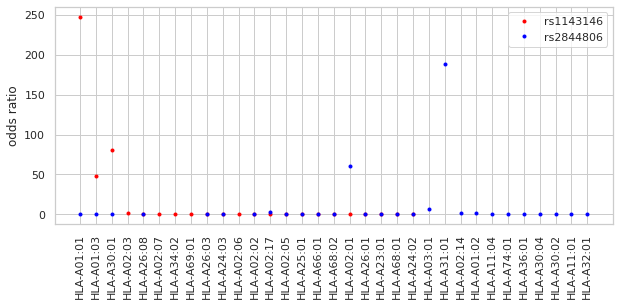

In [91]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.errorbar(df2["hla"],df2["chi"],fmt='.', color='red',label="rs1143146")
plt.errorbar(df["hla"],df["chi"],fmt='.', color='blue',label="rs2844806")
plt.ylabel("odds ratio")
plt.xticks(rotation=90)
plt.legend()
plt.savefig("../hla.odds.ratio.pdf")

In [25]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

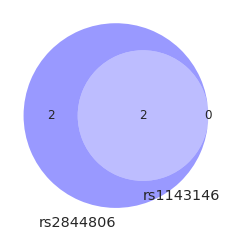

In [29]:
venn2([set(rs2844806),set(rs1143146)],
      set_labels=("rs2844806","rs1143146"), set_colors=["blue","gray"])
plt.savefig("../plots/hla.a.types.pdf")

In [30]:
rs2844806

['HLA-A01:01', 'HLA-A03:01', 'HLA-A01:03', 'HLA-A24:03']

In [31]:
rs1143146

['HLA-A01:01', 'HLA-A01:03']

In [50]:
len(assoc.sort_values(by="pvalue"))

22